<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/Recurrent%20Neural%20Networks%2C%20Time%20Series%2C%20and%20Sequence%20Data/PyTorch_Nonlinear_Sequence_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
series = np.sin((0.1 * np.arange(400)) ** 2)

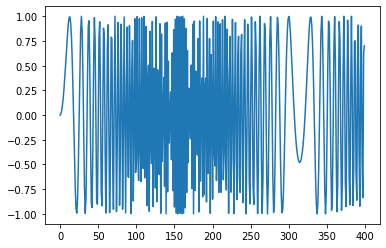

In [3]:
plt.plot(series)
plt.show()

In [4]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t : t + T]
    X.append(x)
    y = series[t + T]
    Y.append(y)
    
X = np.array(X).reshape(-1, T, 1) # make it N x T
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10, 1) Y.shape (390, 1)


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        # note: batch_first=True
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)

        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, (h0, c0))

        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out[:, -1, :])
        return out

In [7]:
# instantiate the model
model = RNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [9]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [10]:
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        loss.backward()
        optimizer.step()

        train_losses[it] = loss.item()

        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 10 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

In [11]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [12]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 10/200, Train Loss: 0.4920, Test Loss: 0.6545
Epoch 20/200, Train Loss: 0.3811, Test Loss: 0.5627
Epoch 30/200, Train Loss: 0.2289, Test Loss: 0.3999
Epoch 40/200, Train Loss: 0.1134, Test Loss: 0.3721
Epoch 50/200, Train Loss: 0.0741, Test Loss: 0.3011
Epoch 60/200, Train Loss: 0.0424, Test Loss: 0.2588
Epoch 70/200, Train Loss: 0.0223, Test Loss: 0.2701
Epoch 80/200, Train Loss: 0.0123, Test Loss: 0.2893
Epoch 90/200, Train Loss: 0.0195, Test Loss: 0.2534
Epoch 100/200, Train Loss: 0.0096, Test Loss: 0.2425
Epoch 110/200, Train Loss: 0.0071, Test Loss: 0.2414
Epoch 120/200, Train Loss: 0.0057, Test Loss: 0.2510
Epoch 130/200, Train Loss: 0.0048, Test Loss: 0.2471
Epoch 140/200, Train Loss: 0.0041, Test Loss: 0.2423
Epoch 150/200, Train Loss: 0.0036, Test Loss: 0.2380
Epoch 160/200, Train Loss: 0.0032, Test Loss: 0.2349
Epoch 170/200, Train Loss: 0.0087, Test Loss: 0.2455
Epoch 180/200, Train Loss: 0.0039, Test Loss: 0.2570
Epoch 190/200, Train Loss: 0.0028, Test Loss: 0.2540
Ep

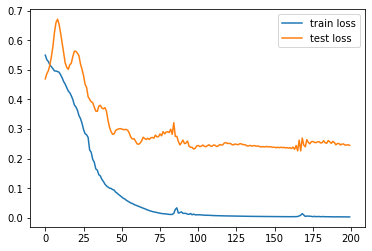

In [13]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [14]:
# One-step forecast using true targets
# NOTE: even the one-step forecast fails badly
validation_target = Y[-N // 2 :]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].view(1, T, -1)
    p = model(input_)[0, 0].item() # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

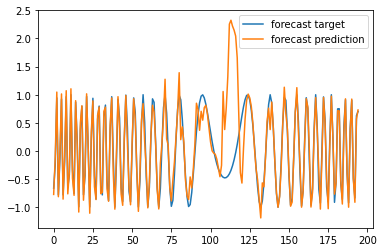

In [15]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()

In [16]:
# Multi-step forecast
validation_target = Y[-N // 2 :]
validation_predictions = []

# last train input
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, -1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar
    
    # update the predictions list
    validation_predictions.append(p[0, 0].item())
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

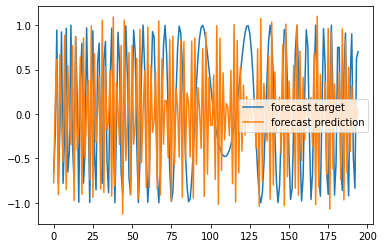

In [17]:
plt.plot(validation_target, label="forecast target")
plt.plot(validation_predictions, label="forecast prediction")
plt.legend()